## **Imports**

In [148]:
!pip install lgnpy &> /dev/nul
!pip install pgmpy &> /dev/nul

In [149]:
from lgnpy import LinearGaussian
import pandas as pd
import numpy as np
from math import prod
import seaborn as sns
from pgmpy.sampling import BayesianModelSampling
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
import math
import networkx as nx

## **Settings**

In [150]:
settings_lg = {'data':'lg','disc_method':'EB', 'target_col':'E','quantiles': 10, 'bins': 10}

settings_sachs = {'data':'sachs','disc_method':'MDLP', 'target_col':'pmek','quantiles': 10, 'bins': 8, 'min_depth':4, 'remove_arrow':('PIP2', 'PIP3'), 'outlier_z':None}

settings_sachs_outlier = {'data':'sachs','disc_method':'EB', 'target_col':'pmek','quantiles': 10, 'bins': 5, 'min_depth':2, 'remove_arrow':('PIP2', 'PIP3'), 'outlier_z':3}

settings_tueb = {'data':'tueb','disc_method':'EV', 'target_col':'B','quantiles': 8, 'bins': 5, 'min_depth':2, 'outlier_z':None}

settings_lalonde = {'data':'lalonde','disc_method':'MDLP', 'target_col':'B','quantiles': 5, 'bins': 5, 'min_depth':2, 'outlier_z':None}

settings = settings_lg

data = settings['data']

# **Core Code**

## **Initiating Linear Gaussian Inference Network**

In [151]:
lg = LinearGaussian()
lg_edges = [('A', 'D'), ('B', 'D')]
lg.set_edges_from(lg_edges)
lg_graph = nx.DiGraph(lg_edges)

In [152]:
objective_ouput_set = [item[1] for item in lg_edges]
objective_input_set = [item[0] for item in lg_edges if item[0] not in objective_ouput_set]
b = [i for sub in lg_edges for i in sub]
set(b)

{'A', 'B', 'D'}

In [153]:
# Set Values:
mu_A, sig_A = 20, 2
mu_B, sig_B = 20, 2

In [154]:
np.random.seed(45)
n=5000
lg_data = pd.DataFrame(columns=['A','B','D'])
lg_data['A'] = np.random.normal(mu_A, sig_A,n)
lg_data['B'] = np.random.normal(mu_B, sig_B,n)
randoms = np.random.normal(0,2,n)
lg_data['D'] = 2*lg_data['A'] + 3*lg_data['B'] + randoms

lg.set_data(lg_data)

In [155]:
lg_data

,A,B,D
0,20.052750,20.230600,103.789670
1,20.520643,19.127646,99.927040
2,19.209709,18.917222,94.392534
3,19.591398,16.704538,89.181426
4,17.456735,19.347661,90.720985
...,...,...,...
4995,23.750647,19.959513,107.052280
4996,20.290540,20.393391,101.201650
4997,15.428746,19.925349,91.425672
4998,19.807305,19.526279,96.609251


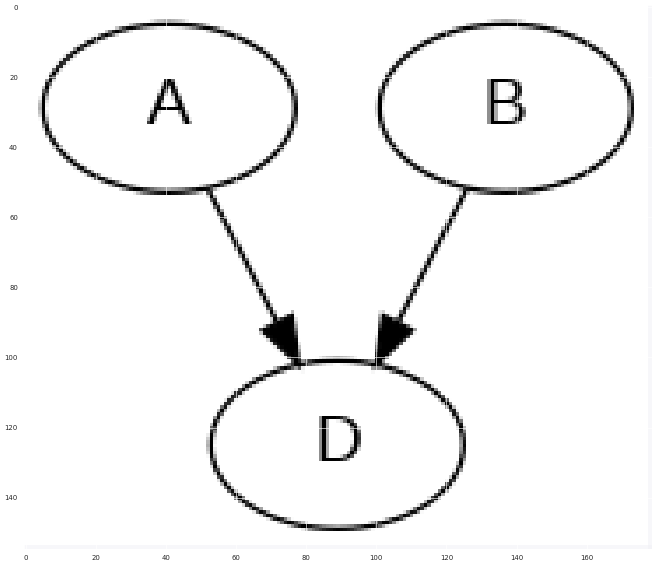

In [156]:
%matplotlib inline
lg.draw_network("my_network", correlation_annotation=False,open=True) #Only first drawn, because all are same

## **Discretization**

In [162]:
data, model_edges, graph = lg_data, lg_edges, lg_graph

In [163]:
class discretizing:
    """
    Class with all discretizing methods 
    """
    def __init__(self, data, quantiles, bins, target_column=None):
      """
      Initiate data and logger and validates input
      :data (pd.Dataframe) : to be converted data
      """
      self.data = data
      self.columns =data.columns
      self.quantiles, self.bins= quantiles, bins
      self.target_column = target_column

    def discretization_EV(self):
      "Equal values: Discretize according to quantiles"
      data = self.data.copy(deep='False')
      cutpoints = []
      for column in self.columns:
        data[column], bin = pd.qcut(data[column], q=self.quantiles, duplicates='drop', retbins=True)
        cutpoints.append(bin)
      return data, np.vstack(cutpoints)

    def discretization_EB(self):
      "Equal length: Discretize according to bins"
      data = self.data.copy(deep='False')
      cutpoints = []
      for column in self.columns:
        data[column], bin = pd.cut(data[column], bins=self.bins, duplicates='drop', retbins=True)
        cutpoints.append(bin)
      #Remove the first and last point
      return data, np.vstack(cutpoints)

    def discretization_MDLP(self, min_length=2):
      "MDLP discretization"
      mdlp = MDLP()
      data = self.data.clip(lower=-50)
      disc_mdlp_result = mdlp.fit_transform(data, data[self.target_column])
      disc_mdlp = pd.DataFrame(disc_mdlp_result, columns=self.columns)
      cutpoints_MLDP = mdlp.cut_points_
      for i in range(len(cutpoints_MLDP)):
        cutpoints_MLDP[i] = np.append(cutpoints_MLDP[i], float('inf'))
        cutpoints_MLDP[i]  = np.append(float('-inf'), cutpoints_MLDP[i])
      cutpoints_MLDP =[cutpoints_MLDP[i] for i in range(len(cutpoints_MLDP))]
      cutpoints_MLDP = np.array(cutpoints_MLDP)
      return disc_mdlp, cutpoints_MLDP

# **Discretization and Error Computation EW 10**

### **Discretize**

Discretize according to Equal Width with 10 bins ans compute the errors to see what happens.

In [164]:
Discretization = discretizing(data=lg_data, quantiles=10, bins=10, target_column='D')
disc_data, cutpoints = Discretization.discretization_EB()


In [165]:
# Initiate Bayesian Network Structure
model_edges = model_edges

model_struct = BayesianNetwork(ebunch = model_edges)
model_struct.nodes()

#Learn Max likelihood Estimator
mle = MaximumLikelihoodEstimator(model=model_struct, data=disc_data)

# Estimating CPDs for all the nodes in the model
all_cpds = mle.get_parameters() # Show 3 CPDs in the output


In [166]:
# Fit Equal Values Bayesian Network
model_struct.fit(disc_data)

In [167]:
# Compute the weighted average of the discretized bins
merged_frame = data.merge(disc_data, left_index=True,right_index=True, suffixes=['_raw','_disc'])
values = [merged_frame.groupby([col+'_disc'])[col+'_raw'].mean().values for col in data.columns]
values_dict = dict(zip(['A','B','D'],values))
dicts = [merged_frame.groupby([col+'_disc'])[col+'_raw'].mean().to_dict() for col in data.columns]
disc_probs =[model_struct.get_cpds(col).values for col in data.columns]
prob_dict = dict(zip(['A','B','D'],disc_probs))

### **Evaluating the Queries**

We are comparing 
\begin{align*}
\mathbb{E}_{disc}[E\mid B_j] \text{   vs    } \frac{1}{|B_j|}\sum_{x_i\in B_j}\mathbb{E}[E\mid x_i].
\end{align*}

where $\mathbb{E}_{disc}[E\mid B_j]$ can only be evaluated on the bins $B_j$ and we are comparing that with the mean of the expected value in the samples of that bin: $\frac{1}{|B_j|}\sum_{x_i\in B_j}\mathbb{E}[E\mid x_i]$.

Because of the following equality
\begin{align*}
\mathbb{E}[E\mid f(B_j)] = \mathbb{E}[E\mid \frac{1}{|B_j|}\sum_{x_i\in B_j}x_i]=\frac{1}{|B_j|}\sum_{x_i\in B_j}\mathbb{E}[E\mid x_i].
\end{align*} 
we could also compute $\mathbb{E}[E\mid f(B_j)]$ for
\begin{align*}
f(B_j)=\frac{1}{|B_j|}\sum_{x_i\in B_j}x_i.
\end{align*} 


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pgmpy/utils/mathext.py:82: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(


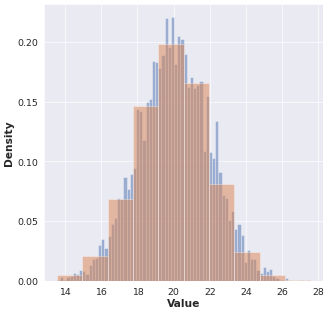

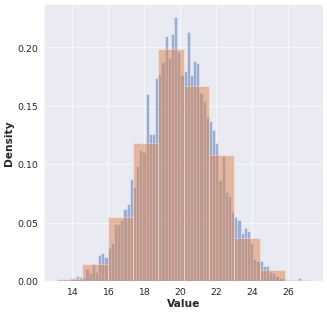

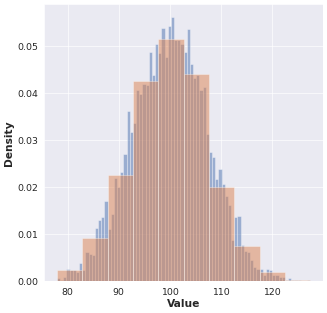

In [168]:
#Sample from the original data:
raw_sample = data.reset_index(drop=True)

# The discretized distribution, we can gather samples from the distribution
inference = BayesianModelSampling(model_struct)
discretized_sample = inference.forward_sample(size=len(data))[data.columns]
for i, col in enumerate(data.columns):
  discretized_sample[col] = discretized_sample[col].map(dicts[i])
discretized_sample.fillna(discretized_sample.mean(), inplace=True)
for i, variable in enumerate(raw_sample.columns):
  plt.figure(figsize=(8,8))
  ax = plt.subplot()
  ax.set_xlabel('Value', fontsize = 17, fontweight="bold") 
  plt.xticks(fontsize = 15)
  plt.yticks(fontsize = 15)
  ax.set_ylabel('Density', fontsize = 17, fontweight="bold")
  ax.hist(raw_sample[variable], bins=80, alpha=0.5, label="raw", density=True)
  ax.hist(discretized_sample[variable].to_numpy(), bins=cutpoints[i], alpha=0.5, label="discretized", density=True)

We compute $\mathbb{E}_{disc}[E\mid B_j]$ by constructing conditonal probability tables from the discretized data and feeding evidence $B_j$. As can be seen in the previous figure, there are very few samples at the edges of the distribution. Therefore, the CPTs resulting from these bins are unreliable. 

In [169]:
# Computed the discretized inference queries
from pgmpy.inference import VariableElimination
infer = VariableElimination(model_struct)
non_nans_b = [x for x in values_dict['D'] if str(x) != 'nan']
disc_sol = []
for value in sorted(disc_data['A'].unique()):
  agg_solution = infer.query(variables=['D'], evidence={'A': value}).values
  disc_sol.append(sum(agg_solution * non_nans_b))
print(disc_sol)

[90.03280109397902, 92.51456795113715, 94.22263082956052, 97.10272988442466, 99.59666204229906, 102.26048073754079, 104.93608177518817, 107.28859688408771, 110.26026531304304, 110.50477863546894]


We compute $\mathbb{E}[E\mid f(B_j)]$ by exact method resulting from the distribution, which can be computed from the following formula's

\begin{align*}
P(Y\mid X) \sim \mathcal{N}(\beta_0+\beta^TX;\sigma^2)
\end{align*}
where the paremeters can be calculated are calculated by parent nodes:
\begin{align*}
\beta_0=\mu_Y-\Sigma_{XY}\Sigma_{XX}^{-1}\mu_X \\
\beta=\Sigma_{XX}^{-1}\Sigma_{YX} \\
\sigma^2= \Sigma_{YY}-\Sigma_{YX}\Sigma_{XX}^{-1}\Sigma_{XY}.
\end{align*}

Note that this techniques makes use of the emperical means of the entire sample size and not just a small part of it as the discretized inference query does.

In [ ]:
import math
exact_sol=[]
for value in sorted(values_dict['A']):
    if not math.isnan(value):
        lg.set_evidences({'A': value})
        inference = lg.run_inference(debug=False)
        exact_sol.append(inference.loc['D','Mean_inferred'])
exact_sol

In [113]:
error_frame=pd.DataFrame()
error_frame['disc_sol'] = disc_sol
error_frame['exact_sol'] = exact_sol
error_frame['error'] = np.abs(error_frame['exact_sol'] - error_frame['disc_sol'])
error_frame['Input_conditonal'] = sorted(values_dict['A'])

<Axes: title={'center': 'Error ($\\mathbb{E}_{disc}[D\\mid B_j]-\\mathbb{E}[D\\mid f(B_j)]$) for each of the bins $B_j$ and associated $f(B_j)$ '}, xlabel='Conditonal $f(B_j)$', ylabel='Error'>

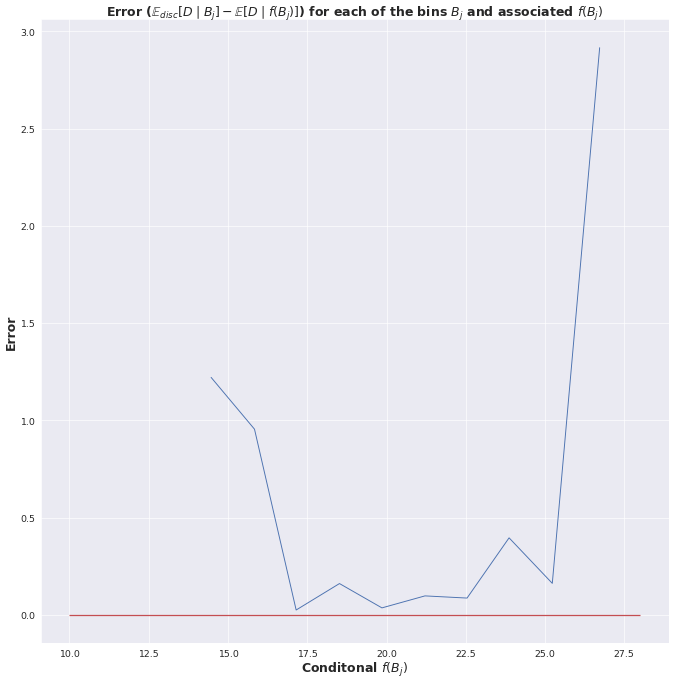

In [114]:
sns.set(style='ticks', context='notebook', font_scale=1.1)
fig.set_size_inches(15, 15)
sns.set(rc={'figure.figsize':(18,18)})
fig, ax = plt.subplots()
ax.set_xlabel('Conditonal $f(B_j)$', fontsize = 20, fontweight="bold") 
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_ylabel('Error', fontsize = 20, fontweight="bold")
ax.hlines(y=0, xmin=10, xmax=28, linewidth=2, color='r')
plt.title("Error ($\mathbb{E}_{disc}[D\mid B_j]-\mathbb{E}[D\mid f(B_j)]$) for each of the bins $B_j$ and associated $f(B_j)$ ",fontsize = 20, fontweight="bold")
sns.lineplot(y="error", x="Input_conditonal", data=error_frame, ax=ax) #change when dd size is available

As can be seen in the plot, the difference between $\mathbb{E}_{disc}[D\mid B_j]$ and $\mathbb{E}[D\mid f(B_j)]$ increases at the edges of the distributions (conditonals where CPTs are the least reliable because of low sample size). These errors will be increasingly penalized when using a squared error error measures such as root mean square or weighted root mean square such as in the following example. But first compute the errors.

### **WRMSE and RMSE**

In [127]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [147]:
rmse = mean_squared_error(exact_sol, disc_sol, squared=False)
wrmse = mean_squared_error(exact_sol, disc_sol, sample_weight = prob_dict['A'], squared=False) # here we compensate for the probability P(f(B_j))
mae = mean_squared_error(exact_sol, disc_sol)

print(f'The root mean squared error is {rmse}, while the weighted root mean squared error is {wrmse} and the mean absolute error is {mae}.')

The root mean squared error is 3.487417925339632, while the weighted root mean squared error is 0.5437422704377446 and the mean absolute error is 12.162083785980183.


# **Discretization and Error Computation EW 20**

### **Discretize**

Discretize according to Equal Width with 20 bins and compute the errors.

In [171]:
Discretization = discretizing(data=lg_data, quantiles=20, bins=20, target_column='D')
disc_data, cutpoints = Discretization.discretization_EB()


In [172]:
# Initiate Bayesian Network Structure
model_edges = model_edges

model_struct = BayesianNetwork(ebunch = model_edges)
model_struct.nodes()

#Learn Max likelihood Estimator
mle = MaximumLikelihoodEstimator(model=model_struct, data=disc_data)

# Estimating CPDs for all the nodes in the model
all_cpds = mle.get_parameters() # Show 3 CPDs in the output


In [173]:
# Fit Equal Values Bayesian Network
model_struct.fit(disc_data)

In [174]:
# Compute the weighted average of the discretized bins
merged_frame = data.merge(disc_data, left_index=True,right_index=True, suffixes=['_raw','_disc'])
values = [merged_frame.groupby([col+'_disc'])[col+'_raw'].mean().values for col in data.columns]
values_dict = dict(zip(['A','B','D'],values))
dicts = [merged_frame.groupby([col+'_disc'])[col+'_raw'].mean().to_dict() for col in data.columns]
disc_probs =[model_struct.get_cpds(col).values for col in data.columns]
prob_dict = dict(zip(['A','B','D'],disc_probs))

### **Evaluating the Queries**

We are comparing 
\begin{align*}
\mathbb{E}_{disc}[E\mid B_j] \text{   vs    } \frac{1}{|B_j|}\sum_{x_i\in B_j}\mathbb{E}[E\mid x_i].
\end{align*}

where $\mathbb{E}_{disc}[E\mid B_j]$ can only be evaluated on the bins $B_j$ and we are comparing that with the mean of the expected value in the samples of that bin: $\frac{1}{|B_j|}\sum_{x_i\in B_j}\mathbb{E}[E\mid x_i]$.

Because of the following equality
\begin{align*}
\mathbb{E}[E\mid f(B_j)] = \mathbb{E}[E\mid \frac{1}{|B_j|}\sum_{x_i\in B_j}x_i]=\frac{1}{|B_j|}\sum_{x_i\in B_j}\mathbb{E}[E\mid x_i].
\end{align*} 
we could also compute $\mathbb{E}[E\mid f(B_j)]$ for
\begin{align*}
f(B_j)=\frac{1}{|B_j|}\sum_{x_i\in B_j}x_i.
\end{align*} 


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pgmpy/utils/mathext.py:82: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  warn(
/usr/local/lib/python3.10/dist-packages/pgmpy/utils/mathext.py:82: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
/usr/local/lib/python3.10/dist-packages/pgmpy/utils/mathext.py:82: UserWarning: Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
  warn(


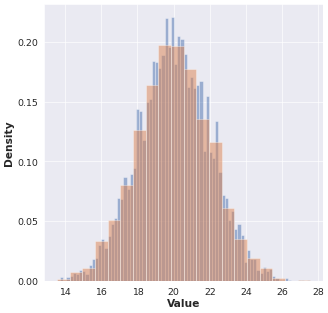

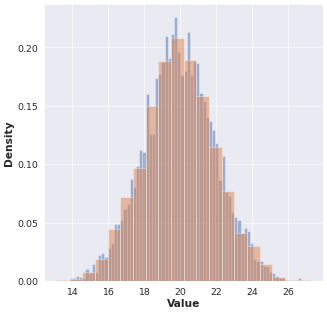

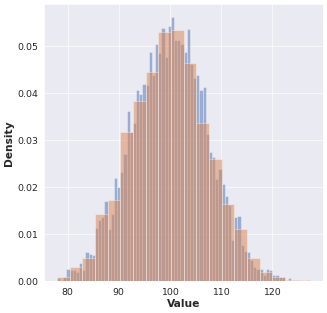

In [175]:
#Sample from the original data:
raw_sample = data.reset_index(drop=True)

# The discretized distribution, we can gather samples from the distribution
inference = BayesianModelSampling(model_struct)
discretized_sample = inference.forward_sample(size=len(data))[data.columns]
for i, col in enumerate(data.columns):
  discretized_sample[col] = discretized_sample[col].map(dicts[i])
discretized_sample.fillna(discretized_sample.mean(), inplace=True)
for i, variable in enumerate(raw_sample.columns):
  plt.figure(figsize=(8,8))
  ax = plt.subplot()
  ax.set_xlabel('Value', fontsize = 17, fontweight="bold") 
  plt.xticks(fontsize = 15)
  plt.yticks(fontsize = 15)
  ax.set_ylabel('Density', fontsize = 17, fontweight="bold")
  ax.hist(raw_sample[variable], bins=80, alpha=0.5, label="raw", density=True)
  ax.hist(discretized_sample[variable].to_numpy(), bins=cutpoints[i], alpha=0.5, label="discretized", density=True)

We compute $\mathbb{E}_{disc}[E\mid B_j]$ by constructing conditonal probability tables from the discretized data and feeding evidence $B_j$. As can be seen in the previous figure, there are very few samples at the edges of the distribution. Therefore, the CPTs resulting from these bins are unreliable. 

In [176]:
# Computed the discretized inference queries
from pgmpy.inference import VariableElimination
infer = VariableElimination(model_struct)
non_nans_b = [x for x in values_dict['D'] if str(x) != 'nan']
disc_sol = []
for value in sorted(disc_data['A'].unique()):
  agg_solution = infer.query(variables=['D'], evidence={'A': value}).values
  disc_sol.append(sum(agg_solution * non_nans_b))
print(disc_sol)

[94.95353567236353, 92.5214193341138, 91.47666762952738, 92.47567481242491, 93.58286529899188, 94.7210304757866, 96.21648929113707, 97.58560322678598, 98.84210511088952, 100.37060732316762, 101.74863110341309, 102.83577673038455, 104.40464483487334, 106.08014299930025, 107.02620471581199, 108.36859950850442, 110.22243032097192, 106.1949949759698, 103.32466128548825, 106.08693014997937]


We compute $\mathbb{E}[E\mid f(B_j)]$ by exact method resulting from the distribution, which can be computed from the following formula's

\begin{align*}
P(Y\mid X) \sim \mathcal{N}(\beta_0+\beta^TX;\sigma^2)
\end{align*}
where the paremeters can be calculated are calculated by parent nodes:
\begin{align*}
\beta_0=\mu_Y-\Sigma_{XY}\Sigma_{XX}^{-1}\mu_X \\
\beta=\Sigma_{XX}^{-1}\Sigma_{YX} \\
\sigma^2= \Sigma_{YY}-\Sigma_{YX}\Sigma_{XX}^{-1}\Sigma_{XY}.
\end{align*}

Note that this techniques makes use of the emperical means of the entire sample size and not just a small part of it as the discretized inference query does.

In [ ]:
import math
exact_sol=[]
for value in sorted(values_dict['A']):
    if not math.isnan(value):
        lg.set_evidences({'A': value})
        inference = lg.run_inference(debug=False)
        exact_sol.append(inference.loc['D','Mean_inferred'])
exact_sol

In [178]:
error_frame=pd.DataFrame()
error_frame['disc_sol'] = disc_sol
error_frame['exact_sol'] = exact_sol
error_frame['error'] = np.abs(error_frame['exact_sol'] - error_frame['disc_sol'])
error_frame['Input_conditonal'] = sorted(values_dict['A'])

<Axes: title={'center': 'Error ($\\mathbb{E}_{disc}[D\\mid B_j]-\\mathbb{E}[D\\mid f(B_j)]$) for each of the bins $B_j$ and associated $f(B_j)$ '}, xlabel='Conditonal $f(B_j)$', ylabel='Error'>

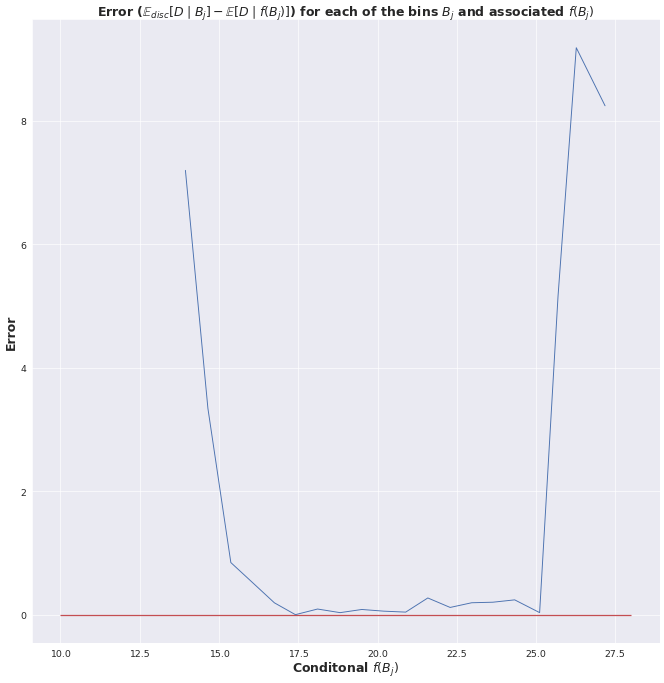

In [179]:
sns.set(style='ticks', context='notebook', font_scale=1.1)
fig.set_size_inches(15, 15)
sns.set(rc={'figure.figsize':(18,18)})
fig, ax = plt.subplots()
ax.set_xlabel('Conditonal $f(B_j)$', fontsize = 20, fontweight="bold") 
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_ylabel('Error', fontsize = 20, fontweight="bold")
ax.hlines(y=0, xmin=10, xmax=28, linewidth=2, color='r')
plt.title("Error ($\mathbb{E}_{disc}[D\mid B_j]-\mathbb{E}[D\mid f(B_j)]$) for each of the bins $B_j$ and associated $f(B_j)$ ",fontsize = 20, fontweight="bold")
sns.lineplot(y="error", x="Input_conditonal", data=error_frame, ax=ax) #change when dd size is available

As can be seen in the plot, the difference between $\mathbb{E}_{disc}[D\mid B_j]$ and $\mathbb{E}[D\mid f(B_j)]$ increases at the edges of the distributions (conditonals where CPTs are the least reliable because of low sample size). These errors will be increasingly penalized when using a squared error error measures such as root mean square or weighted root mean square such as in the following example. But first compute the errors.

### **WRMSE and RMSE**

In [180]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [181]:
rmse = mean_squared_error(exact_sol, disc_sol, squared=False)
wrmse = mean_squared_error(exact_sol, disc_sol, sample_weight = prob_dict['A'], squared=False) # here we compensate for the probability P(f(B_j))
mae = mean_squared_error(exact_sol, disc_sol)

print(f'The root mean squared error is {rmse}, while the weighted root mean squared error is {wrmse} and the mean absolute error is {mae}.')

The root mean squared error is 3.487417925339632, while the weighted root mean squared error is 0.5437422704377446 and the mean absolute error is 12.162083785980183.
